In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller as ADF 
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm 


In [2]:
brent = pd.read_table('brent-daily.txt',header = 0, sep = ",")

In [3]:
WTI = pd.read_table('wti-daily.txt',header = 0, sep = ",")

In [4]:
price_whole = pd.merge(WTI, brent, on = "Date")
price_whole.rename(columns={'Price_x':'WTI','Price_y':'Brent'},inplace = True)
price_whole["WTI_log"] = np.log(price_whole.WTI)
price_whole["Brent_log"] = np.log(price_whole.Brent)
price_whole

/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,WTI,Brent,WTI_log,Brent_log
0,1987-05-20,19.75,18.63,2.983153,2.924773
1,1987-05-21,19.95,18.45,2.993229,2.915064
2,1987-05-22,19.68,18.55,2.979603,2.920470
3,1987-05-26,19.35,18.63,2.962692,2.924773
4,1987-05-27,19.38,18.60,2.964242,2.923162
...,...,...,...,...,...
8309,2020-08-18,42.89,45.34,3.758639,3.814190
8310,2020-08-19,42.91,45.21,3.759105,3.811318
8311,2020-08-20,42.62,44.56,3.752324,3.796837
8312,2020-08-21,42.32,43.94,3.745260,3.782825


#  The Feature of Data

In [5]:
def find_range(start,end):
    year_list = price_whole.Date.apply(lambda x: x.split("-")[0])
    start_index = year_list[year_list == start].index[0]
    end_index = year_list[year_list == end].index[-1]
    price_out = price_whole.loc[start_index:end_index,:]
    return price_out

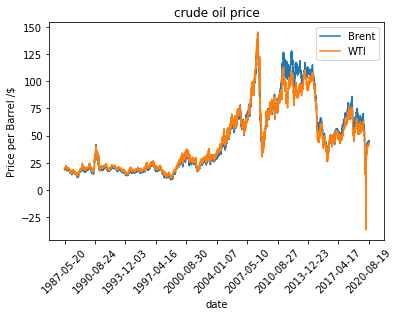

In [6]:
plt.plot(price_whole["Brent"], label = "Brent")
plt.plot(price_whole["WTI"], label = "WTI")
#plt.xticks(range(0,len(price_whole.Date)), price_whole.Date, rotation=90)
each = round(len(price_whole.Date)/10)
plt.xticks(list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each)), list(price_whole.Date[list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each))].values), rotation = 45)
plt.title("crude oil price") 
plt.xlabel("date") 
plt.ylabel("Price per Barrel /$") 
plt.legend()
plt.show()

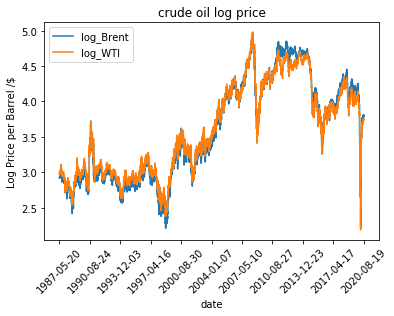

In [7]:
plt.plot(price_whole["Brent_log"], label = "log_Brent")
plt.plot(price_whole["WTI_log"], label = "log_WTI")
#plt.xticks(range(0,len(price_whole.Date)), price_whole.Date, rotation=90)
each = round(len(price_whole.Date)/10)
plt.xticks(list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each)), list(price_whole.Date[list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each))].values), rotation = 45)
plt.title("crude oil log price") 
plt.xlabel("date") 
plt.ylabel("Log Price per Barrel /$") 
plt.legend()
plt.show()

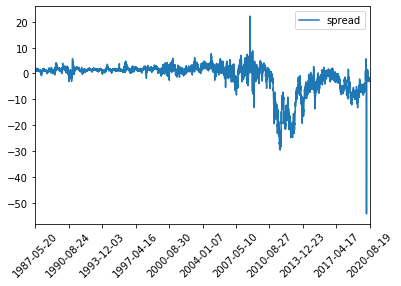

In [8]:
spread=price_whole.WTI-price_whole.Brent
spread_mean=spread.mean()
spread.plot(label='spread')
plt.legend()
each = round(len(price_whole.Date)/10)
plt.xticks(list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each)), list(price_whole.Date[list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each))].values), rotation = 45)
plt.show()

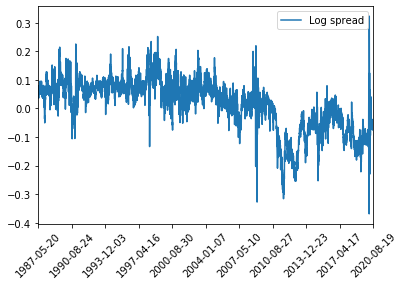

In [9]:
spread=price_whole.WTI_log-price_whole.Brent_log
spread_mean=spread.mean()
spread.plot(label='Log spread')
plt.legend()
each = round(len(price_whole.Date)/10)
plt.xticks(list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each)), list(price_whole.Date[list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each))].values), rotation = 45)
plt.show()

In [10]:
np.corrcoef(price_whole.WTI_log.fillna(method='ffill'), price_whole.Brent_log.fillna(method='ffill'))
# We see the correlation is 0.98988366


array([[1.        , 0.99593371],
       [0.99593371, 1.        ]])

The Brent and WTI are highly correlated, which is consistent with the statement in the article

Therefore, we could be able to do the hedging trading strategy based on these two commodities

# Do ADF test

In [11]:
ret_WTI=price_whole.WTI_log.diff()[1:]
ret_WTI = ret_WTI.fillna(method = "ffill")
adf_ret_WIT=ADF(ret_WTI)
result_ret_WTI = pd.Series(adf_ret_WIT[0:4],
                   index=[
                       'Test Statistic', 'p-value', 'Lags Used',
                       'Number of Observations Used'
                   ])
print(result_ret_WTI)

Test Statistic                -1.840588e+01
p-value                        2.188383e-30
Lags Used                      1.900000e+01
Number of Observations Used    8.293000e+03
dtype: float64


In [12]:
ret_Brent=price_whole.Brent_log.diff()[1:]
ret_Brent = ret_Brent.fillna(method = "ffill")
adf_ret_Brent=ADF(ret_Brent)
result_ret_Brent = pd.Series(adf_ret_Brent[0:4],
                   index=[
                       'Test Statistic', 'p-value', 'Lags Used',
                       'Number of Observations Used'
                   ])
print(result_ret_Brent)

Test Statistic                -1.576726e+01
p-value                        1.172412e-28
Lags Used                      3.000000e+01
Number of Observations Used    8.282000e+03
dtype: float64


Text(0.5, 1.0, 'WTI--Brent log price')

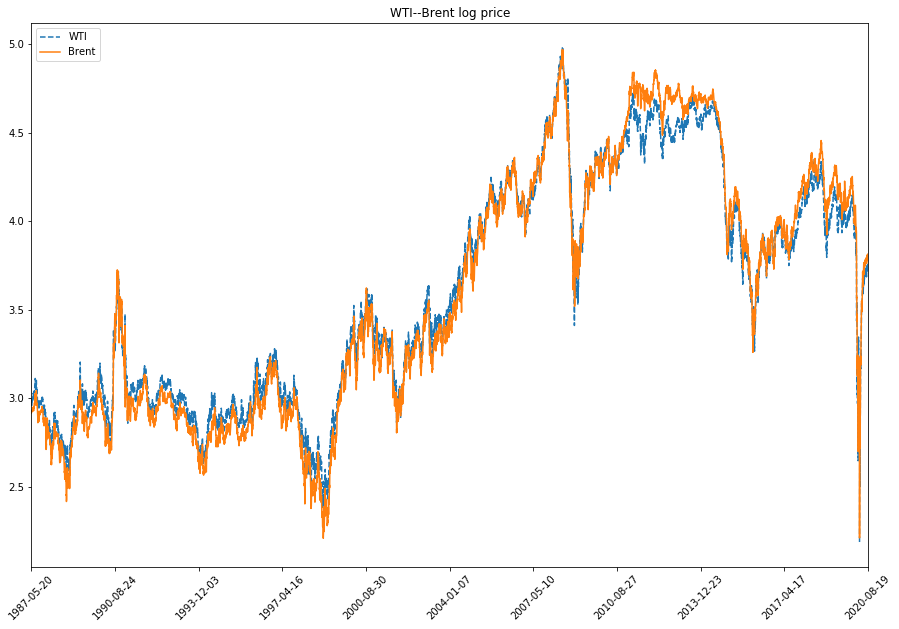

In [13]:
plt.figure(figsize =(15,10))
price_whole.WTI_log.plot(label='WTI',style='--')
price_whole.Brent_log.plot(label='Brent',style='-')
each = round(len(price_whole.Date)/10)
plt.xticks(list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each)), list(price_whole.Date[list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each))].values), rotation = 45)
plt.legend(loc ='upper left')
plt.title('WTI--Brent log price')


Text(0.5, 1.0, 'WTI--Brent first order log price')

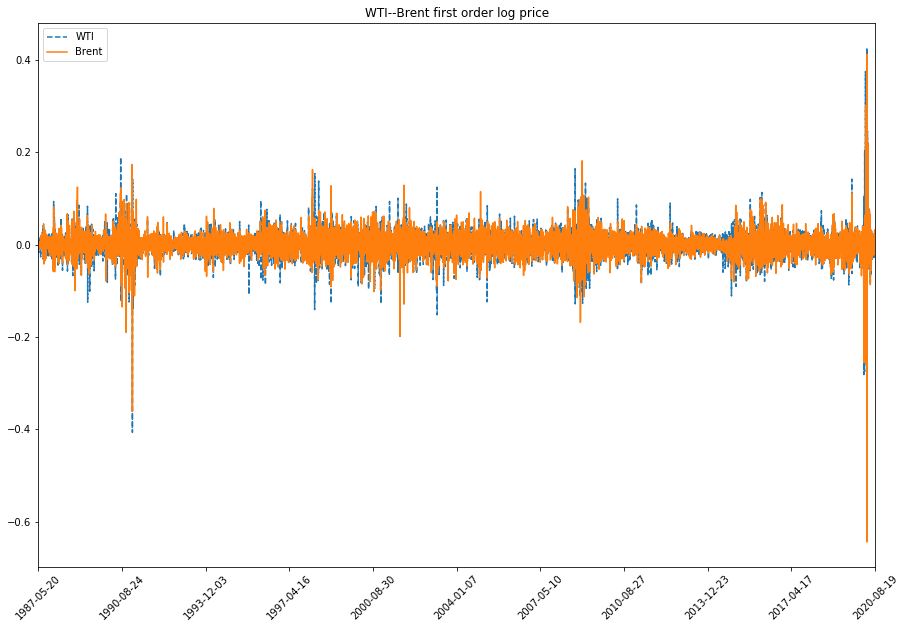

In [14]:
plt.figure(figsize =(15,10))
ret_WTI.plot(label='WTI',style='--')
ret_Brent.plot(label='Brent',style='-')
each = round(len(price_whole.Date)/10)
plt.xticks(list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each)), list(price_whole.Date[list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each))].values), rotation = 45)
plt.legend(loc ='upper left')
plt.title('WTI--Brent first order log price')




In [17]:
print("Therefore, these two commodities can do the hedge trading.")

Therefore, these two commodities can do the hedge trading.


# Implement Strategy

In [18]:
# Transform the price to uniform distribution
# Since the abosolute value would distract our attention from the main point
def plot_trend(price):
    def normed_price(price):
        return (price-np.mean(spread))/np.std(spread)
    spread=price.WTI_log-price.Brent_log
    normed_spread=spread.apply(normed_price)
    plt.figure(figsize=(15,10))
    normed_spread.plot()
    plt.axhline(normed_price(spread_mean), color = "cyan")
    plt.axhline(1,color='green',linestyle='--')
    plt.axhline(-1,color='red',linestyle='--')
    plt.axhline(2,color='green',linestyle='--')
    plt.axhline(-2,color='red',linestyle='--')
    plt.legend(labels=['spread','mean','+1','-1','+1','-2'],loc='best')
    each = round(len(price.Date)/10)
    plt.xticks(list(range(price.Date.index[0],price.Date.index[-1],each)), list(price.Date[list(range(price.Date.index[0],price.Date.index[-1],each))].values), rotation = 45)
    

## Overview of the Data

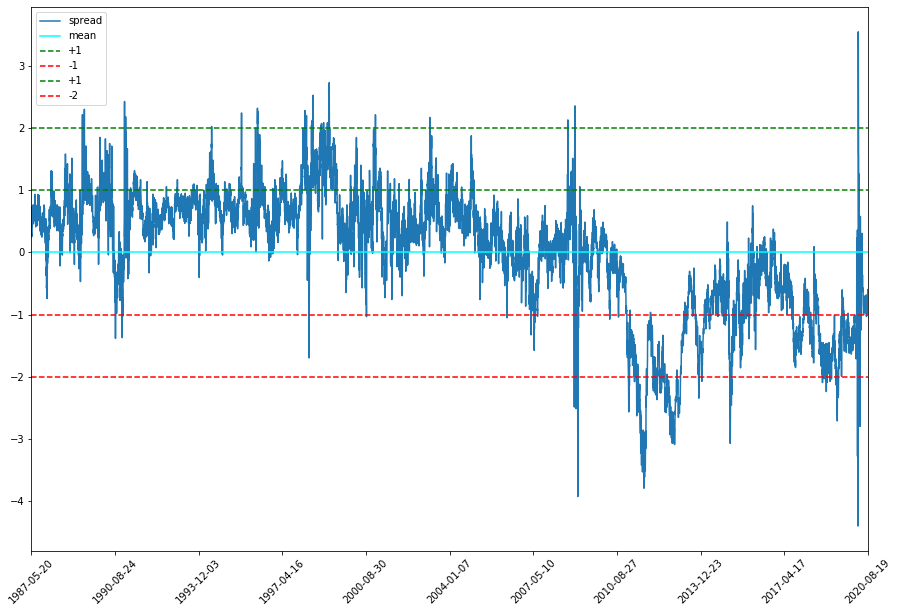

In [19]:
plot_trend(price_whole)

## The Static Ratio trading strategy

In [20]:
def strategy_whole(price, time_range, z):
    year_list = price_whole.Date.apply(lambda x: x.split("-")[0]).unique()
    static_hedge_ratio = []
    for i in range(len(year_list)-1):
        target_df = find_range(year_list[i],year_list[i+1])
        delta_Pw = target_df.WTI_log.iloc[-1] - target_df.WTI_log.iloc[0] 
        delta_Pb = target_df.Brent_log.iloc[-1] - target_df.Brent_log.iloc[0] 
        static_h = delta_Pw/delta_Pb
        static_hedge_ratio.append(static_h)
    static_hedge_ratio = pd.Series(static_hedge_ratio, index = year_list[1:])
    price = price.reset_index(drop = True)
    price_A = price.WTI_log
    price_B = price.Brent_log
    spread = price_A - price_B
    mspread = spread - spread.rolling(time_range).mean()
    sigma = mspread.rolling(time_range).std()
    #open = 2 * sigma
    #stop = 3 * sigma
    open = 2 * sigma
    stop = z * sigma
    stop_loss = 0 * sigma
    commision = 0.001
    profit_list = []
    hold = False
    hold_price_A = 0
    hold_price_B = 0
    hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
    profit_sum = 0
    tarde_info = []
    Long_accurate = 0
    Long_round = 0
    Short_accurate = 0
    Short_round = 0
    gain_round = 0
    gain_profit = 0
    loss_round = 0
    loss_profit = 0
    ratio_list = []
    for i in range(time_range, len(price_A)- 1):
        ratio_year = str(int(price.Date[i].split("-")[0])-1)
        ratio = static_hedge_ratio.loc[ratio_year]
        ratio_list.append(ratio)
        if hold == False:
            if mspread[i] >= open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = -1
                tarde_info.append([price.Date[i],"Short 1 WTI, Long",ratio,"Brent"])
                hold = True
            elif mspread[i] <= -open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = 1
                tarde_info.append([price.Date[i],"Long 1 WTI, Short", ratio,"Brent"])
                #static_hedge_ratio.append(price_A[i + 1] - price_A[i]) / (price_B[i + 1] - price_B[i])
                hold = True
        else:
            
            if mspread[i] <= 0 and hold_state == -1:
                profit = (hold_price_A - price_A[i + 1]) + ratio * (price_B[i + 1] - hold_price_B)
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Short_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Short_round += 1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] >= 0 and hold_state == 1:
                profit = (price_A[i + 1] - hold_price_A) + ratio * (hold_price_B - price_B[i + 1])
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Long_accurate += 1  
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Long_round +=1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
        profit_list.append(profit_sum)
    short_accuracy = Short_accurate/Short_round
    long_accuracy = Long_accurate / Long_round
    exp_gain = gain_profit/gain_round
    exp_loss = loss_profit/loss_round
    hit_ratio = gain_round/loss_round
    
    return [profit_list,tarde_info,short_accuracy,long_accuracy,exp_gain,exp_loss,hit_ratio,ratio_list]


In [21]:
def strategy_test(price, time_range, z, x):
    year_list = price_whole.Date.apply(lambda x: x.split("-")[0]).unique()
    static_hedge_ratio = []
    for i in range(len(year_list)-1):
        target_df = find_range(year_list[i],year_list[i+1])
        delta_Pw = target_df.WTI_log.iloc[-1] - target_df.WTI_log.iloc[0] 
        delta_Pb = target_df.Brent_log.iloc[-1] - target_df.Brent_log.iloc[0] 
        static_h = delta_Pw/delta_Pb
        static_hedge_ratio.append(static_h)
    static_hedge_ratio = pd.Series(static_hedge_ratio, index = year_list[1:])
    price = price.reset_index(drop = True)
    price_A = price.WTI_log
    price_B = price.Brent_log
    spread = price_A - price_B
    mspread = spread - spread.rolling(time_range).mean()
    sigma = mspread.rolling(time_range).std()
    #open = 2 * sigma
    #stop = 3 * sigma
    open = 2 * sigma
    stop = z * sigma
    stop_loss = x * sigma
    commision = 0.001
    profit_list = []
    hold = False
    hold_price_A = 0
    hold_price_B = 0
    hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
    profit_sum = 0
    tarde_info = []
    Long_accurate = 0
    Long_round = 0
    Short_accurate = 0
    Short_round = 0
    gain_round = 0
    gain_profit = 0
    loss_round = 0
    loss_profit = 0
    ratio_list = []
    for i in range(time_range, len(price_A)- 1):
        ratio_year = str(int(price.Date[i].split("-")[0])-1)
        ratio = static_hedge_ratio.loc[ratio_year]
        ratio_list.append(ratio)
        if hold == False:
            if mspread[i] >= open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = -1
                tarde_info.append([price.Date[i],"Short 1 WTI, Long",ratio,"Brent"])
                hold = True
            elif mspread[i] <= -open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = 1
                tarde_info.append([price.Date[i],"Long 1 WTI, Short", ratio,"Brent"])
                #static_hedge_ratio.append(price_A[i + 1] - price_A[i]) / (price_B[i + 1] - price_B[i])
                hold = True
        else:
            if mspread[i] >= stop_loss[i] and hold_state == -1 :
                profit = (hold_price_A - price_A[i + 1]) + ratio * (price_B[i + 1] - hold_price_B)
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Short_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Short_round += 1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] <= -stop_loss[i] and hold_state == 1 :
                profit = (price_A[i + 1] - hold_price_A) + ratio * (hold_price_B - price_B[i + 1])
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Long_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Long_round +=1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] <= stop[i] and hold_state == -1:
                profit = (hold_price_A - price_A[i + 1]) + ratio * (price_B[i + 1] - hold_price_B)
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Short_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Short_round += 1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] >= stop[i] and hold_state == 1:
                profit = (price_A[i + 1] - hold_price_A) + ratio * (hold_price_B - price_B[i + 1])
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Long_accurate += 1  
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Long_round +=1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
        profit_list.append(profit_sum)
    short_accuracy = Short_accurate/Short_round
    long_accuracy = Long_accurate / Long_round
    exp_gain = gain_profit/gain_round
    exp_loss = loss_profit/loss_round
    hit_ratio = gain_round/loss_round
    
    return [profit_list,tarde_info,short_accuracy,long_accuracy,exp_gain,exp_loss,hit_ratio,ratio_list]


In [22]:
def plot_strategy(df,plot_df):
    plot_df = plot_df.reset_index(drop = True)
    trade_info = df[1]
    trade_info
    print("we did",len(trade_info)/2,"rounds of trades")
    profit_list = df[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(df[0])), df[0])
    each = round(len(plot_df.Date)/10)
    plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45)
    plt.show()
    return trade_info

In [23]:
strategy_info_whole1 = strategy_whole(find_range("1989","2020"),100,3)

strategy_info_whole3 = strategy_test(find_range("1989","2020"),100,0.2,3)

we did 31.5 rounds of trades


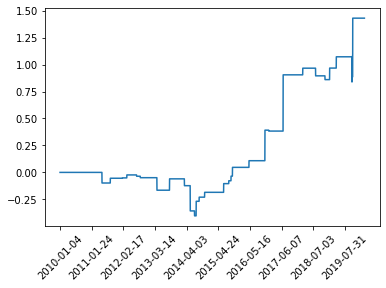

[['2011-01-06', 'Long 1 WTI, Short', 0.880596602715593, 'Brent'],
 ['2011-10-24', 'Close Position'],
 ['2011-11-16', 'Short 1 WTI, Long', 0.880596602715593, 'Brent'],
 ['2012-02-06', 'Close Position'],
 ['2012-06-29', 'Short 1 WTI, Long', 0.6154134727511295, 'Brent'],
 ['2012-07-06', 'Close Position'],
 ['2012-08-02', 'Long 1 WTI, Short', 0.6154134727511295, 'Brent'],
 ['2012-08-28', 'Close Position'],
 ['2012-10-03', 'Long 1 WTI, Short', 0.6154134727511295, 'Brent'],
 ['2012-12-24', 'Close Position'],
 ['2013-01-17', 'Short 1 WTI, Long', 0.018016178675706998, 'Brent'],
 ['2013-02-08', 'Close Position'],
 ['2013-03-25', 'Short 1 WTI, Long', 0.018016178675706998, 'Brent'],
 ['2013-08-29', 'Close Position'],
 ['2013-11-18', 'Long 1 WTI, Short', 0.018016178675706998, 'Brent'],
 ['2014-01-31', 'Close Position'],
 ['2014-07-21', 'Short 1 WTI, Long', 4.500706385698134, 'Brent'],
 ['2014-07-31', 'Close Position'],
 ['2014-09-24', 'Short 1 WTI, Long', 4.500706385698134, 'Brent'],
 ['2014-10-09

In [24]:
strategy_info_2010_2020 = strategy_whole(find_range("2010","2020"),100,0)
plot_strategy(strategy_info_2010_2020,find_range("2010","2020"))

In [25]:
print("expected gain for each gain round is",strategy_info_2010_2020[-4])
print("expected loss for each loss round is",strategy_info_2010_2020[-3])
print("short accuracy is",strategy_info_2010_2020[2])
print("long accuracy is",strategy_info_2010_2020[3])
print(len(strategy_info_2010_2020[1])/2,"trades over the test period")
print("the hit ratio is",strategy_info_2010_2020[-2])

expected gain for each gain round is 0.1182129461841334
expected loss for each loss round is -0.021425158326192142
short accuracy is 0.6
long accuracy is 0.6875
31.5 trades over the test period
the hit ratio is 1.8181818181818181


we did 45.5 rounds of trades


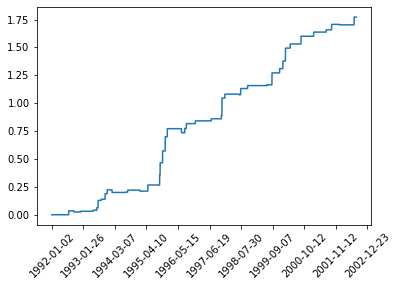

[['1992-11-20', 'Long 1 WTI, Short', 1.0019411864766072, 'Brent'],
 ['1992-12-16', 'Close Position'],
 ['1993-01-25', 'Short 1 WTI, Long', 0.760195394857145, 'Brent'],
 ['1993-02-24', 'Close Position'],
 ['1993-05-13', 'Long 1 WTI, Short', 0.760195394857145, 'Brent'],
 ['1993-05-21', 'Close Position'],
 ['1993-07-14', 'Long 1 WTI, Short', 0.760195394857145, 'Brent'],
 ['1993-07-27', 'Close Position'],
 ['1993-08-25', 'Short 1 WTI, Long', 0.760195394857145, 'Brent'],
 ['1993-10-25', 'Close Position'],
 ['1993-11-24', 'Long 1 WTI, Short', 0.760195394857145, 'Brent'],
 ['1993-11-26', 'Close Position'],
 ['1993-12-06', 'Long 1 WTI, Short', 0.760195394857145, 'Brent'],
 ['1993-12-08', 'Close Position'],
 ['1993-12-13', 'Long 1 WTI, Short', 0.760195394857145, 'Brent'],
 ['1993-12-29', 'Close Position'],
 ['1994-01-10', 'Long 1 WTI, Short', 0.9385787077250434, 'Brent'],
 ['1994-02-09', 'Close Position'],
 ['1994-03-22', 'Long 1 WTI, Short', 0.9385787077250434, 'Brent'],
 ['1994-03-29', 'Close

In [26]:
strategy_info_1992_2002 = strategy_whole(find_range("1992","2002"),100,0)
plot_strategy(strategy_info_1992_2002,find_range("1992","2002"))

In [27]:
print("expected gain for each gain round is",strategy_info_1992_2002[-4])
print("expected loss for each loss round is",strategy_info_1992_2002[-3])
print("short accuracy is",strategy_info_1992_2002[2])
print("long accuracy is",strategy_info_1992_2002[3])
print(len(strategy_info_1992_2002[1])/2,"trades over the test period")
print("the hit ratio is",strategy_info_1992_2002[-2])

expected gain for each gain round is 0.05184118558467318
expected loss for each loss round is -0.00045099898709908594
short accuracy is 0.8571428571428571
long accuracy is 0.75
45.5 trades over the test period
the hit ratio is 4.0


we did 36.5 rounds of trades


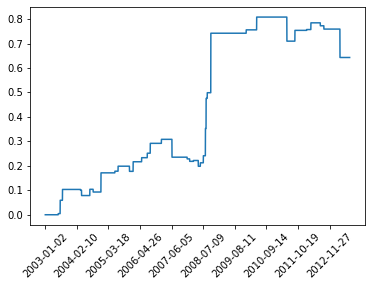

[['2003-10-15', 'Long 1 WTI, Short', 0.5343674501424132, 'Brent'],
 ['2003-11-05', 'Close Position'],
 ['2003-11-18', 'Short 1 WTI, Long', 0.5343674501424132, 'Brent'],
 ['2003-12-02', 'Close Position'],
 ['2003-12-23', 'Short 1 WTI, Long', 0.5343674501424132, 'Brent'],
 ['2004-01-05', 'Close Position'],
 ['2004-07-26', 'Long 1 WTI, Short', 1.0535961727031733, 'Brent'],
 ['2004-08-19', 'Close Position'],
 ['2004-08-23', 'Long 1 WTI, Short', 1.0535961727031733, 'Brent'],
 ['2004-09-01', 'Close Position'],
 ['2004-11-05', 'Short 1 WTI, Long', 1.0535961727031733, 'Brent'],
 ['2004-12-15', 'Close Position'],
 ['2005-01-10', 'Long 1 WTI, Short', 1.1201210043370684, 'Brent'],
 ['2005-01-31', 'Close Position'],
 ['2005-03-23', 'Long 1 WTI, Short', 1.1201210043370684, 'Brent'],
 ['2005-05-09', 'Close Position'],
 ['2005-09-26', 'Short 1 WTI, Long', 1.1201210043370684, 'Brent'],
 ['2005-10-28', 'Close Position'],
 ['2005-11-23', 'Short 1 WTI, Long', 1.1201210043370684, 'Brent'],
 ['2005-12-09',

In [28]:
strategy_info_2003_2013 = strategy_whole(find_range("2003","2013"),100,0)
plot_strategy(strategy_info_2003_2013,find_range("2003","2013"))

In [29]:
print("expected gain for each gain round is",round(strategy_info_2003_2013[-4],4))
print("expected loss for each loss round is",round(strategy_info_2003_2013[-3],4))
print("short accuracy is",round(strategy_info_2003_2013[2],4))
print("long accuracy is",round(strategy_info_2003_2013[3],4))
print(len(strategy_info_2003_2013[1])/2,"trades over the test period")
print("the hit ratio is",strategy_info_2003_2013[-2])

expected gain for each gain round is 0.0439
expected loss for each loss round is -0.0097
short accuracy is 0.7059
long accuracy is 0.6316
36.5 trades over the test period
the hit ratio is 2.0


we did 17.5 rounds of trades


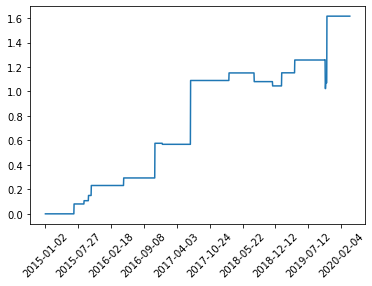

[['2015-11-16', 'Short 1 WTI, Long', 0.7767443508075939, 'Brent'],
 ['2015-11-20', 'Close Position'],
 ['2015-12-22', 'Short 1 WTI, Long', 0.7767443508075939, 'Brent'],
 ['2016-01-26', 'Close Position'],
 ['2016-02-11', 'Long 1 WTI, Short', 0.8702156426195512, 'Brent'],
 ['2016-02-23', 'Close Position'],
 ['2016-02-26', 'Long 1 WTI, Short', 0.8702156426195512, 'Brent'],
 ['2016-03-10', 'Close Position'],
 ['2016-08-29', 'Long 1 WTI, Short', 0.8702156426195512, 'Brent'],
 ['2016-09-27', 'Close Position'],
 ['2017-03-08', 'Long 1 WTI, Short', -2.541587765039845, 'Brent'],
 ['2017-04-11', 'Close Position'],
 ['2017-05-25', 'Long 1 WTI, Short', -2.541587765039845, 'Brent'],
 ['2017-05-26', 'Close Position'],
 ['2017-08-03', 'Long 1 WTI, Short', -2.541587765039845, 'Brent'],
 ['2017-11-17', 'Close Position'],
 ['2018-06-26', 'Short 1 WTI, Long', 0.8142799671173241, 'Brent'],
 ['2018-07-23', 'Close Position'],
 ['2018-10-23', 'Long 1 WTI, Short', 0.8142799671173241, 'Brent'],
 ['2018-12-28',

In [30]:
strategy_info_2015_2020 = strategy_whole(find_range("2015","2020"),100,0)
plot_strategy(strategy_info_2015_2020,find_range("2015","2020"))

In [31]:
print("expected gain for each gain round is",round(strategy_info_2015_2020[-4],4))
print("expected loss for each loss round is",round(strategy_info_2015_2020[-3],4))
print("short accuracy is",round(strategy_info_2015_2020[2],4))
print("long accuracy is",round(strategy_info_2015_2020[3],4))
print(len(strategy_info_2015_2020[1])/2,"trades over the test period")
print("the hit ratio is",strategy_info_2015_2020[-2])

expected gain for each gain round is 0.1512
expected loss for each loss round is -0.0589
short accuracy is 0.75
long accuracy is 0.7778
17.5 trades over the test period
the hit ratio is 3.25


we did 124.5 rounds of trades


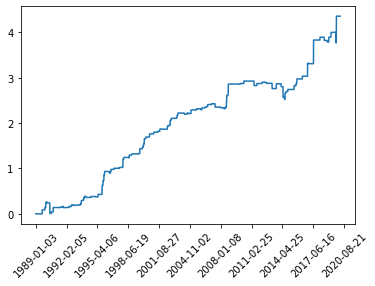

[['1990-01-05', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-01-17', 'Close Position'],
 ['1990-01-24', 'Short 1 WTI, Long', 1.2945259707163161, 'Brent'],
 ['1990-04-24', 'Close Position'],
 ['1990-05-23', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-05-29', 'Close Position'],
 ['1990-06-13', 'Short 1 WTI, Long', 1.2945259707163161, 'Brent'],
 ['1990-06-15', 'Close Position'],
 ['1990-06-20', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-06-28', 'Close Position'],
 ['1990-07-25', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-10-18', 'Close Position'],
 ['1990-12-05', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-12-18', 'Close Position'],
 ['1991-01-09', 'Short 1 WTI, Long', 0.9023218249601537, 'Brent'],
 ['1991-02-21', 'Close Position'],
 ['1991-09-30', 'Long 1 WTI, Short', 0.9023218249601537, 'Brent'],
 ['1991-11-20', 'Close Position'],
 ['1991-12-20', 'Long 1 WTI, Short', 0.9023218249601537, 'Brent'],
 ['1991-12-31',

In [32]:
strategy_info_whole = strategy_whole(find_range("1989","2020"),100,0.2)
plot_strategy(strategy_info_whole,find_range("1989","2020"))

In [33]:
print("expected gain for each gain round is",strategy_info_whole[-4])
print("expected loss for each loss round is",strategy_info_whole[-3])
print("short accuracy is",strategy_info_whole[2])
print("long accuracy is",strategy_info_whole[3])
print(len(strategy_info_whole[1])/2,"trades over the test period")
print("the hit ratio is",strategy_info_whole[-2])

expected gain for each gain round is 0.06277328517394827
expected loss for each loss round is -0.007602475535100437
short accuracy is 0.7796610169491526
long accuracy is 0.7230769230769231
124.5 trades over the test period
the hit ratio is 3.0


we did 150.5 rounds of trades


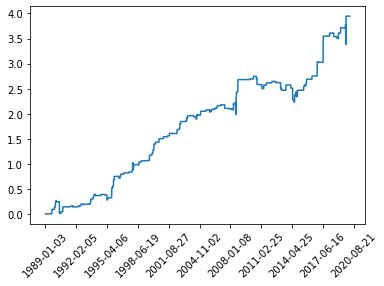

[['1990-01-05', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-01-17', 'Close Position'],
 ['1990-01-24', 'Short 1 WTI, Long', 1.2945259707163161, 'Brent'],
 ['1990-04-24', 'Close Position'],
 ['1990-05-23', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-05-29', 'Close Position'],
 ['1990-06-13', 'Short 1 WTI, Long', 1.2945259707163161, 'Brent'],
 ['1990-06-15', 'Close Position'],
 ['1990-06-20', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-06-28', 'Close Position'],
 ['1990-07-25', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-10-18', 'Close Position'],
 ['1990-12-05', 'Long 1 WTI, Short', 1.2945259707163161, 'Brent'],
 ['1990-12-18', 'Close Position'],
 ['1991-01-09', 'Short 1 WTI, Long', 0.9023218249601537, 'Brent'],
 ['1991-02-21', 'Close Position'],
 ['1991-09-30', 'Long 1 WTI, Short', 0.9023218249601537, 'Brent'],
 ['1991-11-20', 'Close Position'],
 ['1991-12-20', 'Long 1 WTI, Short', 0.9023218249601537, 'Brent'],
 ['1991-12-31',

In [34]:
strategy_info_test = strategy_test(find_range("1989","2020"),100,0,4)
plot_strategy(strategy_info_test,find_range("1989","2020"))

In [35]:
print("expected gain for each gain round is",round(strategy_info_test[-4],4))
print("expected loss for each loss round is",round(strategy_info_test[-3],4))
print("short accuracy is",round(strategy_info_test[2],4))
print("long accuracy is",round(strategy_info_test[3],4))
print(len(strategy_info_test[1])/2,"trades over the test period")
print("the hit ratio is",round(strategy_info_test[-2],4))

expected gain for each gain round is 0.0627
expected loss for each loss round is -0.0007
short accuracy is 0.7123
long accuracy is 0.6753
150.5 trades over the test period
the hit ratio is 2.2609


Text(0.5, 1.0, 'w/o stopp loss')

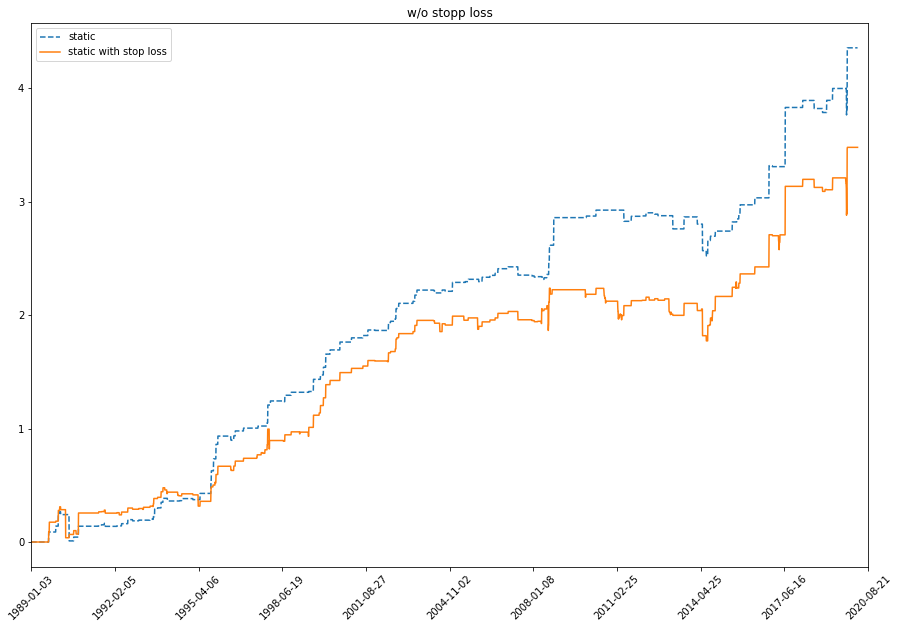

In [36]:
strategy_info_whole = strategy_whole(find_range("1989","2020"),100,0.2)
plt.figure(figsize =(15,10))
pd.Series(strategy_info_whole[0]).plot(label='static',style='--')
pd.Series(strategy_test(find_range("1989","2020"),100,0,3)[0]).plot(label='static with stop loss',style='-')
plot_df = find_range("1989","2020").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('w/o stopp loss')

In [37]:
print("expected gain for each gain round is",round(strategy_info_whole[-4],4))
print("expected loss for each loss round is",round(strategy_info_whole[-3],4))
print("short accuracy is",round(strategy_info_whole[2],4))
print("long accuracy is",round(strategy_info_whole[3],4))
print(len(strategy_info_whole[1])/2,"trades over the test period")
print("the hit ratio is",round(strategy_info_whole[-2],4))

expected gain for each gain round is 0.0628
expected loss for each loss round is -0.0076
short accuracy is 0.7797
long accuracy is 0.7231
124.5 trades over the test period
the hit ratio is 3.0


# Static Hedge Ratio

In [38]:
year_list = price_whole.Date.apply(lambda x: x.split("-")[0]).unique()
static_hedge_ratio = []
for i in range(len(year_list)-1):
    target_df = find_range(year_list[i],year_list[i+1])
    delta_Pw = target_df.WTI.iloc[-1] - target_df.WTI.iloc[0] 
    delta_Pb = target_df.Brent.iloc[-1] - target_df.Brent.iloc[0] 
    static_h = delta_Pw/delta_Pb
    static_hedge_ratio.append(static_h)

In [39]:
pd.Series(static_hedge_ratio, index = year_list[1:])

1988    1.095833
1989    1.312903
1990    0.928870
1991    1.081159
1992    0.788354
1993    0.998095
1994    0.840000
1995    0.934866
1996    1.053616
1997    0.705502
1998    0.964055
1999    0.911572
2000    1.228522
2001    1.217391
2002    0.585949
2003    1.118977
2004    1.201477
2005    1.050307
2006    0.927512
2007    1.020827
2008    0.713277
2009    1.060209
2010    0.898986
2011    0.596074
2012    0.016021
2013    4.094017
2014    0.687749
2015    0.813262
2016   -2.452381
2017    0.776683
2018    1.609375
2019    0.687500
2020    0.401869
dtype: float64

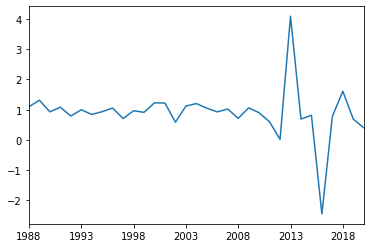

In [40]:
pd.Series(static_hedge_ratio, index = year_list[1:]).plot()

# Dynamic Hedge Ratio

In [41]:
from pykalman import KalmanFilter

In [42]:
def KalmanFilterAverage(x):
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
     observation_matrices = [1],
     initial_state_mean = 0,
     initial_state_covariance = 1,
     observation_covariance=1,
     transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 0.0025
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
     initial_state_mean=[0,0],
     initial_state_covariance=np.ones((2, 2)),
     transition_matrices=np.eye(2),
     observation_matrices=obs_mat,
     observation_covariance=2,
     transition_covariance=trans_cov)
# Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y)
    return state_means

In [43]:
state_means = KalmanFilterRegression(KalmanFilterAverage(price_whole.Brent_log),KalmanFilterAverage(price_whole.WTI_log))
dynamic_hedge_ratio = state_means[:,0]
dynamic_hedge_ratio

array([0.45549798, 0.57094077, 0.62177333, ...,        nan,        nan,
              nan])

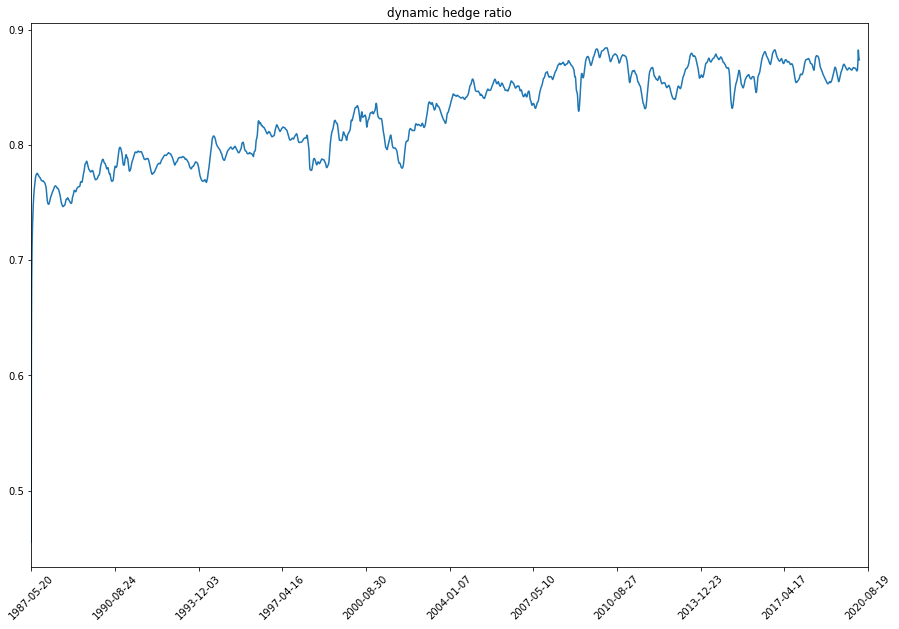

In [44]:
plt.figure(figsize =(15,10))
pd.Series(dynamic_hedge_ratio).plot()
each = round(len(price_whole.Date)/10)
plt.xticks(list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each)), list(price_whole.Date[list(range(price_whole.Date.index[0],price_whole.Date.index[-1],each))].values), rotation = 45);
plt.title("dynamic hedge ratio");




In [45]:
def dynamic_strategy_whole(price, time_range, z):
    state_means = KalmanFilterRegression(KalmanFilterAverage(price.Brent),KalmanFilterAverage(price.WTI))
    dynamic_hedge_ratio = state_means[:,0]
    price["dynamic_ratio"] = dynamic_hedge_ratio
    price = price.reset_index(drop = True)
    price_A = price.WTI_log
    price_B = price.Brent_log
    spread = price_A - price_B
    mspread = spread - spread.rolling(time_range).mean()
    sigma = mspread.rolling(time_range).std()
    #open = 2 * sigma
    #stop = 3 * sigma
    open = 2 * sigma
    stop = z * sigma
    commision = 0.001
    profit_list = []
    hold = False
    hold_price_A = 0
    hold_price_B = 0
    hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
    profit_sum = 0
    tarde_info = []
    Long_accurate = 0
    Long_round = 0
    Short_accurate = 0
    Short_round = 0
    gain_round = 0
    gain_profit = 0
    loss_round = 0
    loss_profit = 0
    ratio_list = []
    
    for i in range(time_range, len(price_A)- 1):
        ratio = price.loc[i,"dynamic_ratio"]
        if hold == False:
            if mspread[i] >= open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = -1
                tarde_info.append([price.Date[i],"Short 1 WTI, Long",ratio,"Brent"])
                hold = True
            elif mspread[i] <= -open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = 1
                tarde_info.append([price.Date[i],"Long 1 WTI, Short", ratio,"Brent"])
                #static_hedge_ratio.append(price_A[i + 1] - price_A[i]) / (price_B[i + 1] - price_B[i])
                hold = True
        else:
            
            if mspread[i] <= 0 and hold_state == -1:
                profit = (hold_price_A - price_A[i + 1]) + ratio * (price_B[i + 1] - hold_price_B)
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Short_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Short_round += 1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] >= 0 and hold_state == 1:
                profit = (price_A[i + 1] - hold_price_A) + ratio * (hold_price_B - price_B[i + 1])
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Long_accurate += 1  
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Long_round +=1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
        profit_list.append(profit_sum)
    short_accuracy = Short_accurate/Short_round
    long_accuracy = Long_accurate / Long_round
    exp_gain = gain_profit/gain_round
    exp_loss = loss_profit/loss_round
    hit_ratio = gain_round/loss_round
    
    return [profit_list,tarde_info,short_accuracy,long_accuracy,exp_gain,exp_loss,hit_ratio,ratio_list]


In [46]:
def dynamic_strategy_test(price, time_range, z, x):
    state_means = KalmanFilterRegression(KalmanFilterAverage(price.Brent),KalmanFilterAverage(price.WTI))
    dynamic_hedge_ratio = state_means[:,0]
    price["dynamic_ratio"] = dynamic_hedge_ratio
    price = price.reset_index(drop = True)
    price_A = price.WTI_log
    price_B = price.Brent_log
    spread = price_A - price_B
    mspread = spread - spread.rolling(time_range).mean()
    sigma = mspread.rolling(time_range).std()
    #open = 2 * sigma
    #stop = 3 * sigma
    open = 2 * sigma
    stop = z * sigma
    stop_loss = x * sigma
    commision = 0.001
    profit_list = []
    hold = False
    hold_price_A = 0
    hold_price_B = 0
    hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
    profit_sum = 0
    tarde_info = []
    Long_accurate = 0
    Long_round = 0
    Short_accurate = 0
    Short_round = 0
    gain_round = 0
    gain_profit = 0
    loss_round = 0
    loss_profit = 0
    ratio_list = []
    for i in range(time_range, len(price_A)- 1):
        ratio = price.loc[i,"dynamic_ratio"]
        if hold == False:
            if mspread[i] >= open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = -1
                tarde_info.append([price.Date[i],"Short 1 WTI, Long",ratio,"Brent"])
                hold = True
            elif mspread[i] <= -open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = 1
                tarde_info.append([price.Date[i],"Long 1 WTI, Short", ratio,"Brent"])
                #static_hedge_ratio.append(price_A[i + 1] - price_A[i]) / (price_B[i + 1] - price_B[i])
                hold = True
        else:
            if mspread[i] >= stop_loss[i] and hold_state == -1 :
                profit = (hold_price_A - price_A[i + 1]) + ratio * (price_B[i + 1] - hold_price_B)
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Short_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Short_round += 1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] <= -stop_loss[i] and hold_state == 1 :
                profit = (price_A[i + 1] - hold_price_A) + ratio * (hold_price_B - price_B[i + 1])
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Long_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Long_round +=1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] <= stop[i] and hold_state == -1:
                profit = (hold_price_A - price_A[i + 1]) + ratio * (price_B[i + 1] - hold_price_B)
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Short_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Short_round += 1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] >= stop[i] and hold_state == 1:
                profit = (price_A[i + 1] - hold_price_A) + ratio * (hold_price_B - price_B[i + 1])
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Long_accurate += 1  
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Long_round +=1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
        profit_list.append(profit_sum)
    short_accuracy = Short_accurate/Short_round
    long_accuracy = Long_accurate / Long_round
    exp_gain = gain_profit/gain_round
    exp_loss = loss_profit/loss_round
    hit_ratio = gain_round/loss_round
    
    return [profit_list,tarde_info,short_accuracy,long_accuracy,exp_gain,exp_loss,hit_ratio,ratio_list]

/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Dynamic--Static profit')

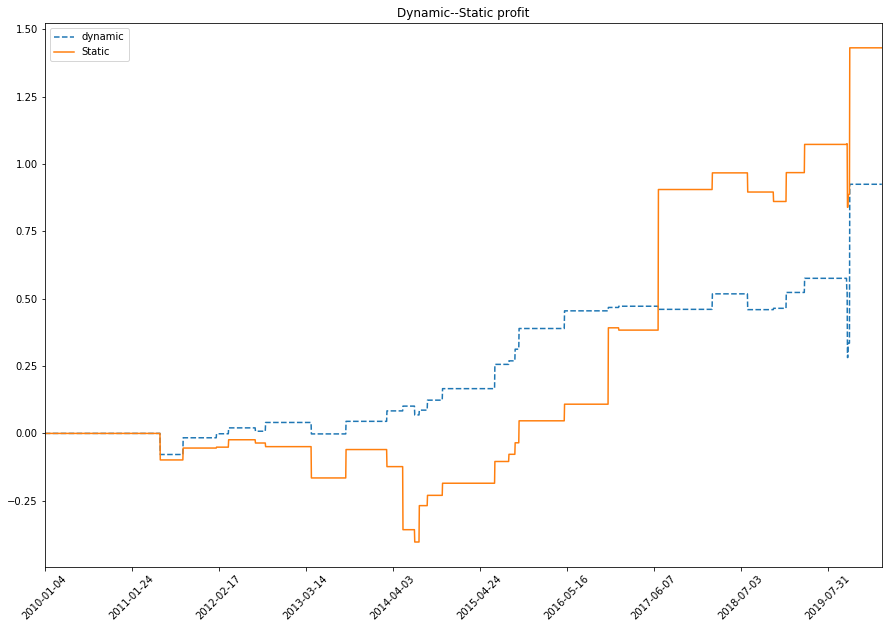

In [47]:
dynamic_strategy_info_2010_2020 = dynamic_strategy_whole(find_range("2010","2020"), 100, 0)
plt.figure(figsize =(15,10))
pd.Series(dynamic_strategy_info_2010_2020[0]).plot(label='dynamic',style='--')
pd.Series(strategy_info_2010_2020[0]).plot(label='Static',style='-')
plot_df = find_range("2010","2020").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('Dynamic--Static profit')

In [48]:
print("expected gain for each gain round is",dynamic_strategy_info_2010_2020[-4])
print("expected loss for each loss round is",dynamic_strategy_info_2010_2020[-3])
print("short accuracy is",dynamic_strategy_info_2010_2020[2])
print("long accuracy is",dynamic_strategy_info_2010_2020[3])
print(len(dynamic_strategy_info_2010_2020[1])/2,"trades over the test period")
print("the hit ratio is",dynamic_strategy_info_2010_2020[-2])

expected gain for each gain round is 0.06322927399052179
expected loss for each loss round is -0.030702817794745926
short accuracy is 0.8
long accuracy is 0.6875
31.5 trades over the test period
the hit ratio is 2.875


/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Dynamic--Static profit')

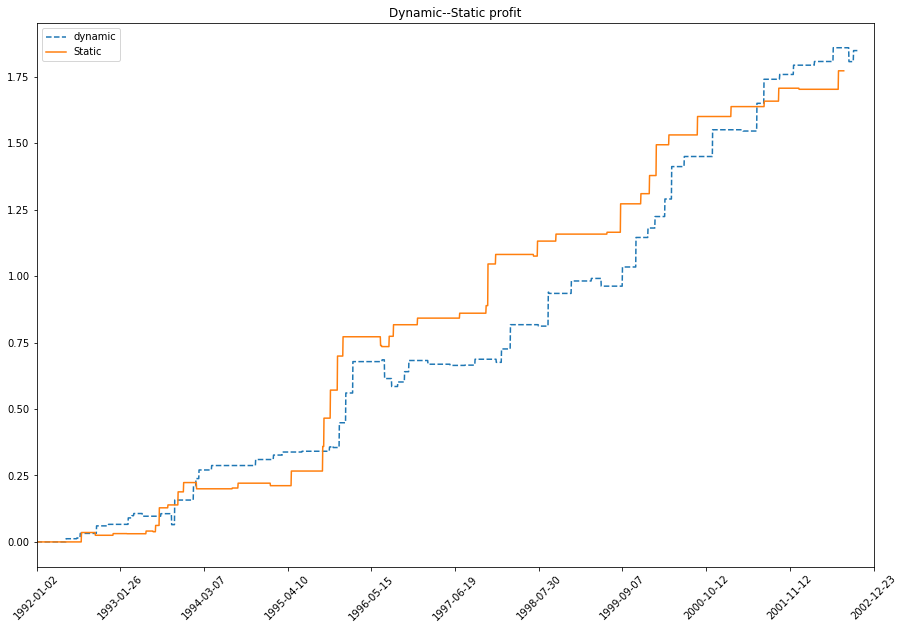

In [49]:
dynamic_strategy_info_1992_2002 = dynamic_strategy_whole(find_range("1992","2002"), 50, 0)
plt.figure(figsize =(15,10))
pd.Series(dynamic_strategy_info_1992_2002[0]).plot(label='dynamic',style='--')
pd.Series(strategy_info_1992_2002[0]).plot(label='Static',style='-')
plot_df = find_range("1992","2002").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('Dynamic--Static profit')

In [50]:
print("expected gain for each gain round is",dynamic_strategy_info_1992_2002[-4])
print("expected loss for each loss round is",dynamic_strategy_info_1992_2002[-3])
print("short accuracy is",dynamic_strategy_info_1992_2002[2])
print("long accuracy is",dynamic_strategy_info_1992_2002[3])
print(len(dynamic_strategy_info_1992_2002[1])/2,"trades over the test period")
print("the hit ratio is",dynamic_strategy_info_1992_2002[-2])

expected gain for each gain round is 0.04264202463680271
expected loss for each loss round is -0.004019350654927134
short accuracy is 0.875
long accuracy is 0.7096774193548387
63.5 trades over the test period
the hit ratio is 3.8461538461538463


/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Dynamic--Static profit')

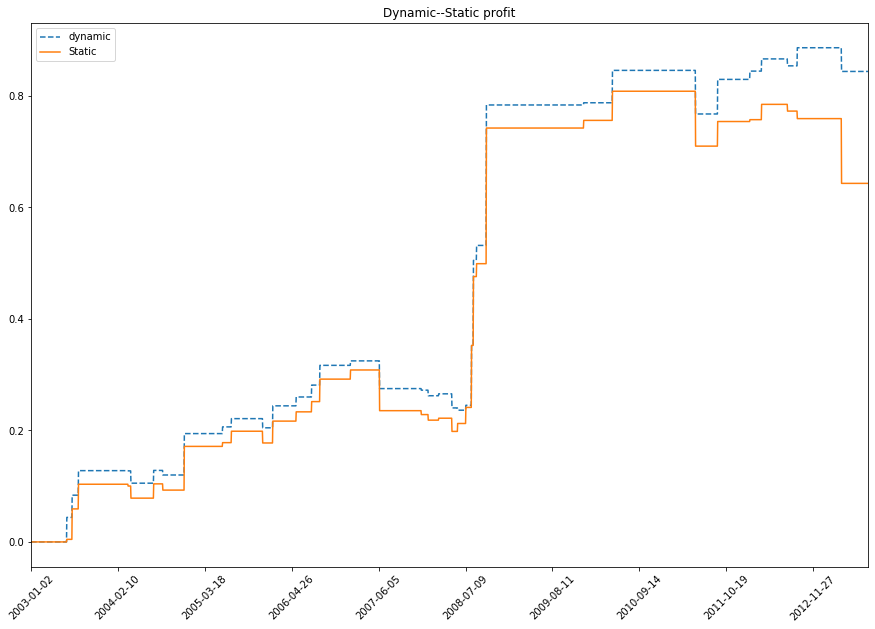

In [51]:
dynamic_strategy_info_2003_2013 = dynamic_strategy_whole(find_range("2003","2013"), 100, 0)
plt.figure(figsize =(15,10))
pd.Series(dynamic_strategy_info_2003_2013[0]).plot(label='dynamic',style='--')
pd.Series(strategy_info_2003_2013[0]).plot(label='Static',style='-')
plot_df = find_range("2003","2013").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('Dynamic--Static profit')

/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Dynamic')

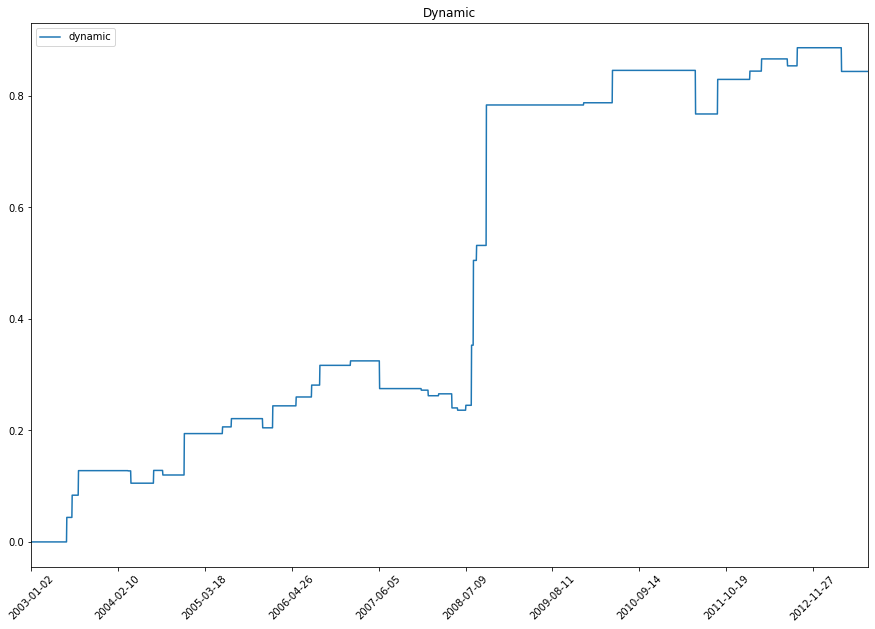

In [52]:
dynamic_strategy_info_2003_2013 = dynamic_strategy_whole(find_range("2003","2013"), 100, 0)
plt.figure(figsize =(15,10))
pd.Series(dynamic_strategy_info_2003_2013[0]).plot(label='dynamic',style='-')
#pd.Series(strategy_info_2003_2013[0]).plot(label='Static',style='-')
plot_df = find_range("2003","2013").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('Dynamic')

In [53]:
print("expected gain for each gain round is",round(dynamic_strategy_info_2003_2013[-4],4))
print("expected loss for each loss round is",round(dynamic_strategy_info_2003_2013[-3],4))
print("short accuracy is",round(dynamic_strategy_info_2003_2013[2],4))
print("long accuracy is",round(dynamic_strategy_info_2003_2013[3],4))
print(len(dynamic_strategy_info_2003_2013[1])/2,"trades over the test period")
print("the hit ratio is",dynamic_strategy_info_2003_2013[-2])

expected gain for each gain round is 0.0465
expected loss for each loss round is -0.0035
short accuracy is 0.7059
long accuracy is 0.6316
36.5 trades over the test period
the hit ratio is 2.0


/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Dynamic--Static profit')

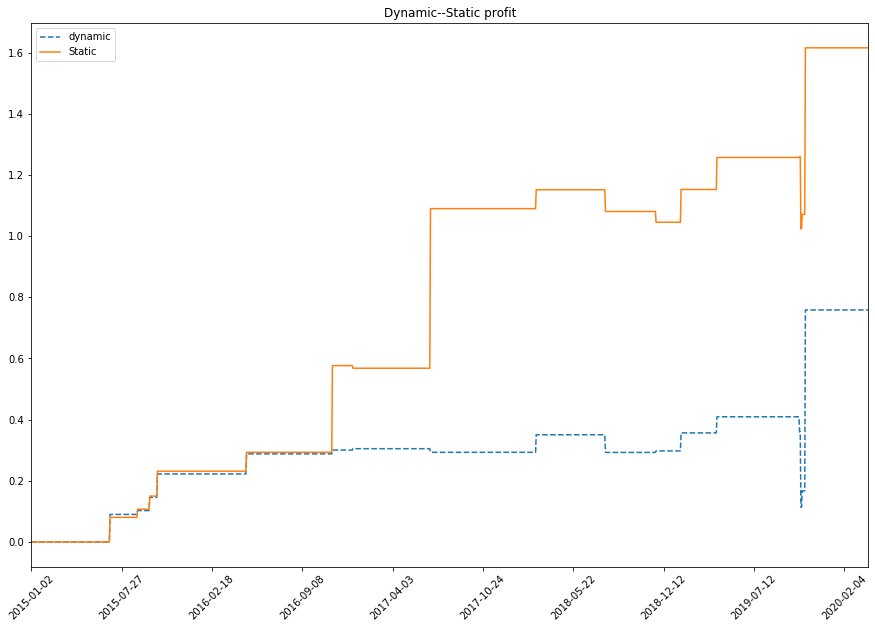

In [54]:
dynamic_strategy_info_2015_2020 = dynamic_strategy_whole(find_range("2015","2020"), 100, 0)
plt.figure(figsize =(15,10))
pd.Series(dynamic_strategy_info_2015_2020[0]).plot(label='dynamic',style='--')
pd.Series(strategy_info_2015_2020[0]).plot(label='Static',style='-')
plot_df = find_range("2015","2020").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('Dynamic--Static profit')

/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Dynamic profit')

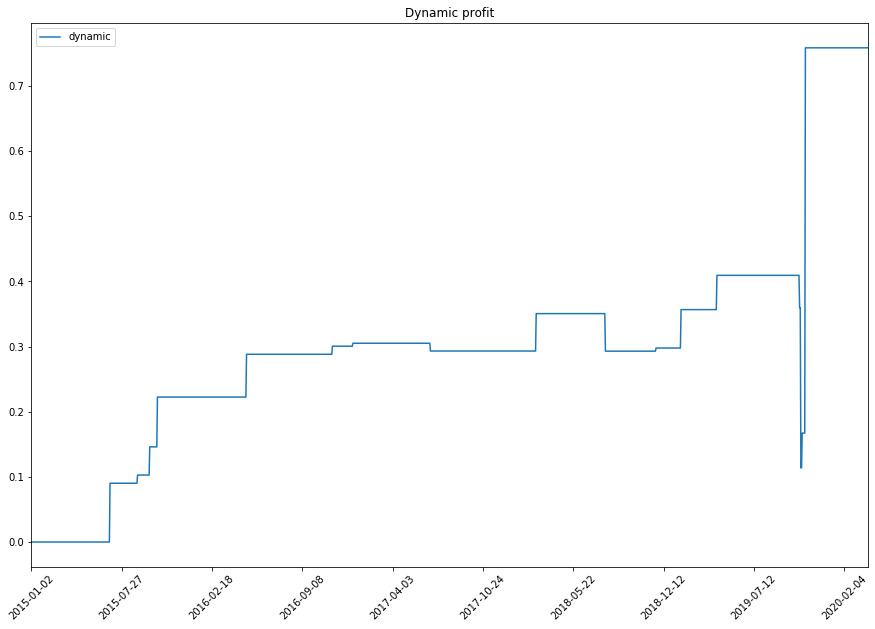

In [55]:
dynamic_strategy_info_2015_2020 = dynamic_strategy_whole(find_range("2015","2020"), 100, 0)
plt.figure(figsize =(15,10))
pd.Series(dynamic_strategy_info_2015_2020[0]).plot(label='dynamic',style='-')
#pd.Series(strategy_info_2015_2020[0]).plot(label='Static',style='-')
plot_df = find_range("2015","2020").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('Dynamic profit')

In [56]:
print("expected gain for each gain round is",round(dynamic_strategy_info_2015_2020[-4],4))
print("expected loss for each loss round is",round(dynamic_strategy_info_2015_2020[-3],4))
print("short accuracy is",dynamic_strategy_info_2015_2020[2])
print("long accuracy is",round(dynamic_strategy_info_2015_2020[3],4))
print(len(dynamic_strategy_info_2015_2020[1])/2,"trades over the test period")
print("the hit ratio is",dynamic_strategy_info_2015_2020[-2])

expected gain for each gain round is 0.0864
expected loss for each loss round is -0.0615
short accuracy is 0.75
long accuracy is 0.7778
17.5 trades over the test period
the hit ratio is 3.25


/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Dynamic--Static profit')

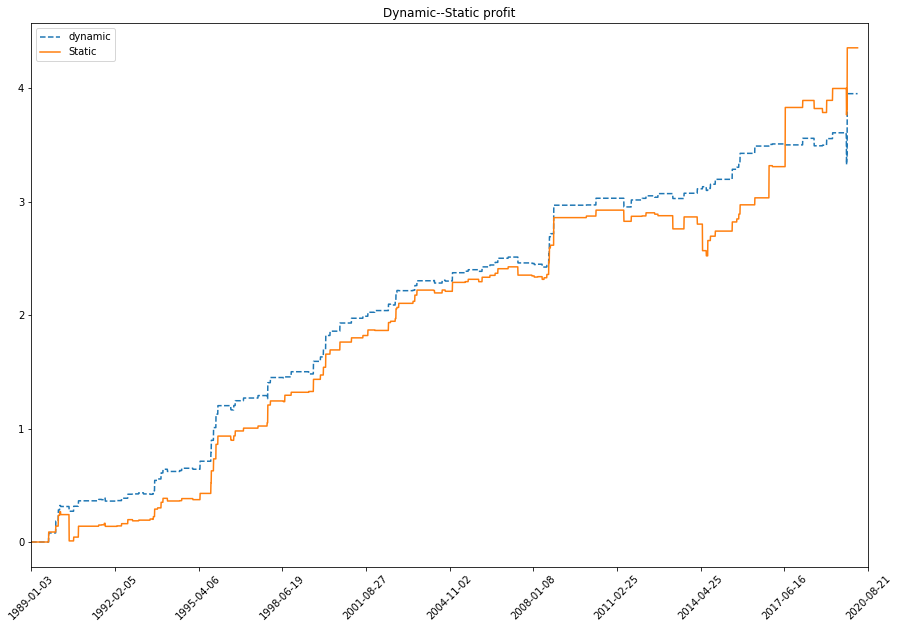

In [57]:
dynamic_strategy_info_whole = dynamic_strategy_whole(find_range("1989","2020"), 100, 0)
plt.figure(figsize =(15,10))
pd.Series(dynamic_strategy_info_whole[0]).plot(label='dynamic',style='--')
pd.Series(strategy_info_whole[0]).plot(label='Static',style='-')
plot_df = find_range("1989","2020").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('Dynamic--Static profit')

/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Dynamic')

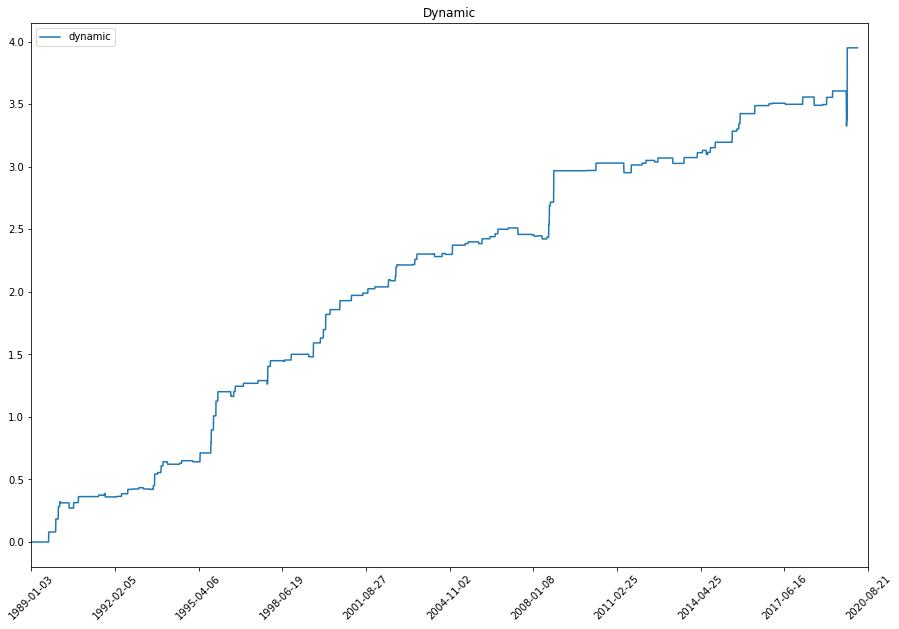

In [58]:
dynamic_strategy_info_whole = dynamic_strategy_whole(find_range("1989","2020"), 100, 0)
plt.figure(figsize =(15,10))
pd.Series(dynamic_strategy_info_whole[0]).plot(label='dynamic',style='-')
#pd.Series(strategy_info_whole[0]).plot(label='Static',style='-')
plot_df = find_range("1989","2020").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('Dynamic')

In [59]:
print("expected gain for each gain round is",round(dynamic_strategy_info_whole[-4],4))
print("expected loss for each loss round is",round(dynamic_strategy_info_whole[-3],4))
print("short accuracy is",round(dynamic_strategy_info_whole[2],4))
print("long accuracy is",round(dynamic_strategy_info_whole[3],4))
print(len(dynamic_strategy_info_whole[1])/2,"trades over the test period")
print("the hit ratio is",dynamic_strategy_info_whole[-2])

expected gain for each gain round is 0.0519
expected loss for each loss round is -0.0078
short accuracy is 0.7966
long accuracy is 0.7077
124.5 trades over the test period
the hit ratio is 3.0


In [60]:
test = dynamic_strategy_test(find_range("1989","2020"), 100, 0,3)

/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [61]:
print("expected gain for each gain round is",round(test[-4],4))
print("expected loss for each loss round is",round(test[-3],4))
print("short accuracy is",round(test[2],4))
print("long accuracy is",round(test[3],4))
print(len(test[1])/2,"trades over the test period")
print("the hit ratio is",round(test[-2],4))

expected gain for each gain round is 0.0455
expected loss for each loss round is -0.0003
short accuracy is 0.5979
long accuracy is 0.6
212.5 trades over the test period
the hit ratio is 1.4941


/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'w/o stopp loss')

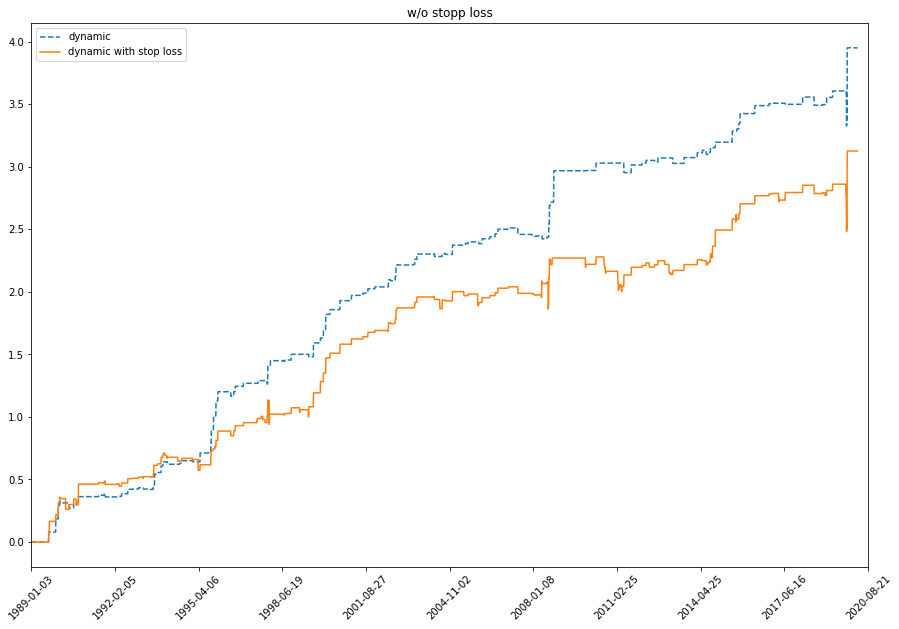

In [62]:
dynamic_strategy_info_whole = dynamic_strategy_whole(find_range("1989","2020"), 100, 0)
plt.figure(figsize =(15,10))
pd.Series(dynamic_strategy_info_whole[0]).plot(label='dynamic',style='--')
pd.Series(test[0]).plot(label='dynamic with stop loss',style='-')
plot_df = find_range("1989","2020").reset_index(drop = True)
each = round(len(plot_df.Date)/10)
plt.xticks(list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each)), list(plot_df.Date[list(range(plot_df.Date.index[0],plot_df.Date.index[-1],each))].values), rotation = 45);
plt.legend(loc ='upper left')
plt.title('w/o stopp loss')


# Further Direction

In [68]:
def half_life(spread):
    spread = spread.dropna()
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params.iloc[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

In [69]:
test_spread = find_range("1988","1999")
test_spread = test_spread.reset_index(drop = True)
test_spread = test_spread.WTI_log - test_spread.Brent_log
test_spread = test_spread.dropna()
print("the half life of each mean-reverting process is",half_life(test_spread))


the half life of each mean-reverting process is 5


Since I have been set up the standard process of the hedging trading strategy.

It would be easier to fit this proces to other commodities.

Also, for the static hegding strategy, we could first calculate the half life of for the last period, and set the rolling wind to the half life, to see how this influences the performance.

In [77]:
def with_half_life(price, length, z, x):
    state_means = KalmanFilterRegression(KalmanFilterAverage(price.Brent),KalmanFilterAverage(price.WTI))
    dynamic_hedge_ratio = state_means[:,0]
    price["dynamic_ratio"] = dynamic_hedge_ratio
    price = price.reset_index(drop = True)
    price_A = price.WTI_log
    price_B = price.Brent_log
    spread = price_A - price_B
    #open = 2 * sigma
    #stop = 3 * sigma
    commision = 0.001
    profit_list = []
    hold = False
    hold_price_A = 0
    hold_price_B = 0
    hold_state = 0   # 1 (A:long B:short)   -1 (A:short B:long)
    profit_sum = 0
    tarde_info = []
    Long_accurate = 0
    Long_round = 0
    Short_accurate = 0
    Short_round = 0
    gain_round = 0
    gain_profit = 0
    loss_round = 0
    loss_profit = 0
    ratio_list = []
    
    for i in range(length, len(price_A)- 1):
        time_range = half_life(spread.loc[i-length: i,])
        mspread = spread - spread.rolling(time_range).mean()
        sigma = mspread.rolling(time_range).std()
        if hold == False:
            open = 2 * sigma
            stop = z * sigma
            stop_loss = x * sigma
        ratio = price.loc[i,"dynamic_ratio"]
        if hold == False:
            if mspread[i] >= open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = -1
                tarde_info.append([price.Date[i],"Short 1 WTI, Long",ratio,"Brent"])
                hold = True
            elif mspread[i] <= -open[i]:
                hold_price_A = price_A[i+1]
                hold_price_B = price_B[i+1]
                hold_state = 1
                tarde_info.append([price.Date[i],"Long 1 WTI, Short", ratio,"Brent"])
                #static_hedge_ratio.append(price_A[i + 1] - price_A[i]) / (price_B[i + 1] - price_B[i])
                hold = True
        else:
            if mspread[i] >= stop_loss[i] and hold_state == -1 :
                profit = (hold_price_A - price_A[i + 1]) + ratio * (price_B[i + 1] - hold_price_B)
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Short_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Short_round += 1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] <= -stop_loss[i] and hold_state == 1 :
                profit = (price_A[i + 1] - hold_price_A) + ratio * (hold_price_B - price_B[i + 1])
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Long_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Long_round +=1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] <= stop[i] and hold_state == -1:
                profit = (hold_price_A - price_A[i + 1]) + ratio * (price_B[i + 1] - hold_price_B)
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Short_accurate += 1
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Short_round += 1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
            if mspread[i] >= stop[i] and hold_state == 1:
                profit = (price_A[i + 1] - hold_price_A) + ratio * (hold_price_B - price_B[i + 1])
                profit_sum += profit * (1 - commision)
                hold_state = 0
                if profit > 0:
                    gain_round += 1
                    Long_accurate += 1  
                    gain_profit += profit * (1 - commision)
                elif profit < 0:
                    loss_round += 1
                    loss_profit = profit * (1 - commision)
                Long_round +=1
                tarde_info.append([price.Date[i],"Close Position"])
                hold = False
        profit_list.append(profit_sum)
    short_accuracy = Short_accurate/Short_round
    long_accuracy = Long_accurate / Long_round
    exp_gain = gain_profit/gain_round
    exp_loss = loss_profit/loss_round
    hit_ratio = gain_round/loss_round
    
    return [profit_list,tarde_info,short_accuracy,long_accuracy,exp_gain,exp_loss,hit_ratio,ratio_list]

In [79]:
test_half = with_half_life(find_range("1989","2020"), 100, 0,3)

/Users/yipeizhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


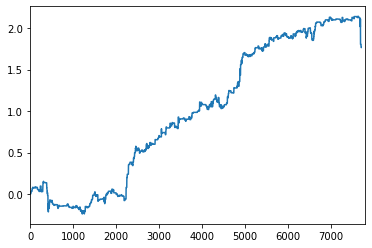

In [82]:
pd.Series(test_half[0]).plot()